# Electricity Forecasting - FB Prophet

用 Prophet 來預測被轉容量
https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from prophet import Prophet
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

/opt/anaconda3/envs/python3_8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 參數設定

In [2]:
n_tests = 15 # numbers of days reserved for testing
start_offset_first = 0
start_offset_second = 0
start_offset_final = 0
# dependencies = ['op_reserve_ratio']
# dependencies = ['peak_supply']
dependencies = ['peak_supply', 'op_reserve_ratio']
first_forecast = 'peak_supply'
second_forecast = 'op_reserve_ratio'
regressors_first = ['is_holiday', 'month', 'year', 'day']
if first_forecast in dependencies:
    regressors_second = [first_forecast, 'is_holiday', 'month', 'year', 'day']
else:
    regressors_second = ['is_holiday', 'month', 'year', 'day']
regressors_op_reserve = dependencies + ['is_holiday', 'day_of_week', 'month']
print(regressors_op_reserve)

['peak_supply', 'op_reserve_ratio', 'is_holiday', 'day_of_week', 'month']


## Data Collation / Wrangling

In [3]:
'''
load data
'''
raw_data = []
raw_data = pd.DataFrame(raw_data)

holiday_data = []
holiday_data = pd.DataFrame(holiday_data)

file = '台灣電力公司_過去電力供需資訊2017.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(MW)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
for idx, date in enumerate(raw_data_new['date']):
    raw_data_new['op_reserve'][idx] /= 10
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

raw_data = pd.concat([raw_data, raw_data_new])

file = '台灣電力公司_過去電力供需資訊2018.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(MW)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
for idx, date in enumerate(raw_data_new['date']):
    raw_data_new['op_reserve'][idx] /= 10
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

raw_data = pd.concat([raw_data, raw_data_new])

file = '近三年每日尖峰備轉容量率2019-2021.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(萬瓩)', '備轉容量率(%)']]
# print(raw_data_new)
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

raw_data = pd.concat([raw_data, raw_data_new])

file =  '台灣電力公司_本年度每日尖峰備轉容量率2022.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,[True,True,True]]
raw_data_new.columns = ['date', 'op_reserve', 'op_reserve_ratio']
raw_data_new['date'] = pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

raw_data = pd.concat([raw_data,raw_data_new])

for file in ['106年政府機關辦公日曆表.csv',
             '107政府機關辦公日曆表(數字版).csv',
             '108年中華民國政府行政機關辦公日曆表.csv',
             '109年中華民國政府行政機關辦公日曆表.csv',
             '110中華民國政府行政機關辦公日曆表.csv',
             '111年中華民國政府行政機關辦公日曆表.csv']:
    raw_data_new = pd.read_csv(file)
    raw_data_new = pd.DataFrame(raw_data_new)
    raw_data_new = raw_data_new.loc[:,[True, False, True, False]]
    raw_data_new.columns=['date','is_holiday']
    for idx, date in enumerate(raw_data_new['date']):
        date = str(raw_data_new['date'][idx])
        raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
    raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
    raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
    raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
    raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
    raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

    holiday_data = pd.concat([holiday_data, raw_data_new])

raw_data = holiday_data.merge(raw_data)

'''
Trim outliers & convert unit
'''
# FIXME: use difference instead?
op_reserve_mean = round(float(raw_data['op_reserve'].mean()), 1)
raw_data['peak_supply'] = raw_data['op_reserve_ratio'].values
for i, op_reserve in enumerate(raw_data['op_reserve']):
    raw_data['op_reserve'][i] = raw_data['op_reserve'][i] * 10
    raw_data['peak_supply'][i] = raw_data['op_reserve'][i] * 100 / raw_data['op_reserve_ratio'][i]
    
'''
split training set and testing set
'''
train = raw_data[start_offset_first:-n_tests]
test = raw_data[-n_tests:]

<AxesSubplot:xlabel='date'>

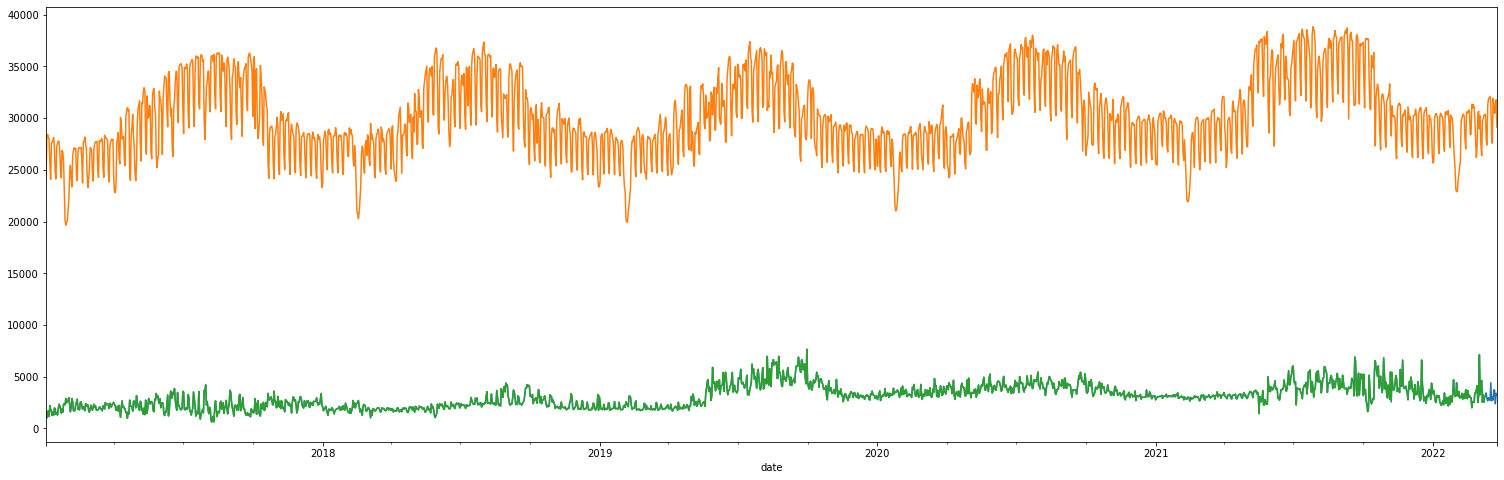

In [4]:
raw_data_tmp = raw_data[:]
raw_data_tmp.set_index('date',inplace=True)
raw_data_tmp['op_reserve'].plot(label='first_data', figsize=(26,8))
raw_data_tmp['peak_supply'].plot(label='first_data', figsize=(26,8))

train_tmp = train[:]
train_tmp.set_index('date',inplace=True)
train_tmp['op_reserve'].plot(label='first_data', figsize=(26,8))

<AxesSubplot:xlabel='date'>

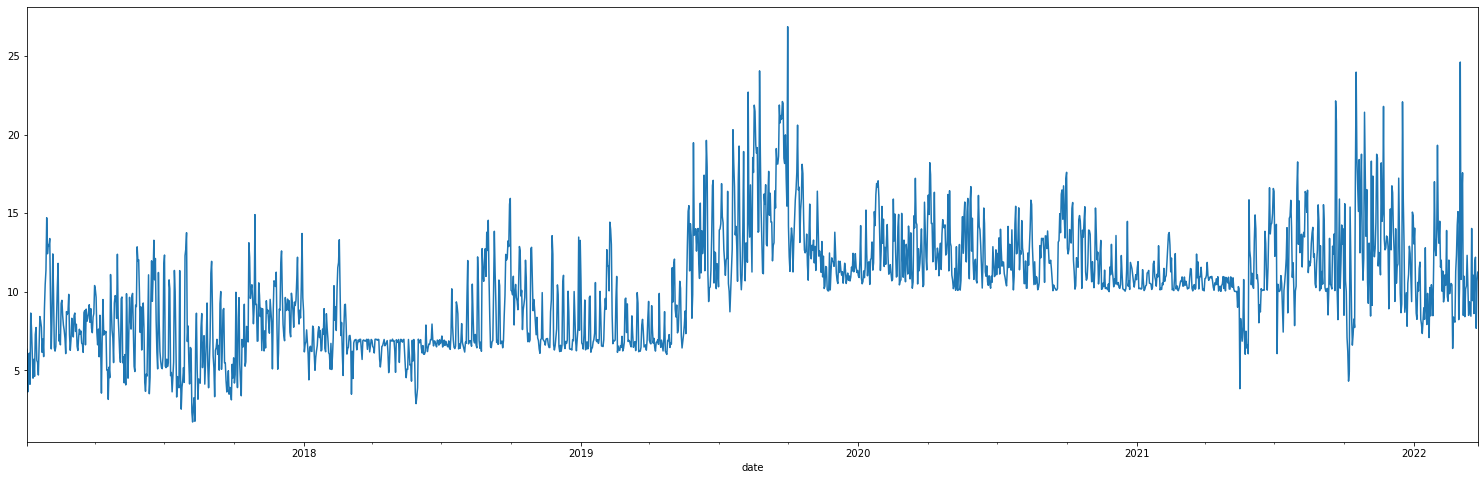

In [5]:
raw_data_tmp['op_reserve_ratio'].plot(label='first_data', figsize=(26,8))

## FB Prophet

### 先預測尖峰供電

In [6]:
prophet_data = train[:]
prophet_data.rename(columns={first_forecast: 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [7]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=True, 
                weekly_seasonality=False, 
                seasonality_mode='additive')
for regressor in regressors_first:
    model.add_regressor(regressor)
model.fit(prophet_data)

Initial log joint probability = -16.0135


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5532.17    0.00802495       530.309           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5534.3   0.000471192       146.396           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5535.34   0.000248707       285.594      0.5339      0.5339      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     396       5535.78   7.47863e-05       83.8542   1.143e-06       0.001      509  LS failed, Hessian reset 
     399       5535.78   1.79205e-05       93.7257      0.5673      0.5673      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5535.86   1.09158e-06       75.8077           1           1      6

In [8]:
prophet_data.tail()

,index,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,y
1890,1890,2022-03-07,0,2022,3,7,0,2527.0,8.50,29729.411765
1891,1891,2022-03-08,0,2022,3,8,1,3290.0,10.99,29936.305732
1892,1892,2022-03-09,0,2022,3,9,2,2550.0,8.42,30285.035629
1893,1893,2022-03-10,0,2022,3,10,3,3088.0,10.18,30333.988212
1894,1894,2022-03-11,0,2022,3,11,4,3148.0,10.37,30356.798457


In [9]:
future = test.rename(columns={'date': 'ds'})
# future.drop(['op_reserve'], axis = 1, inplace=True)
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,peak_supply
1895,2022-03-12,2,2022,3,12,5,3438.0,12.32,27905.844156
1896,2022-03-13,2,2022,3,13,6,2839.0,10.36,27403.474903
1897,2022-03-14,0,2022,3,14,0,2659.0,8.50,31282.352941
1898,2022-03-15,0,2022,3,15,1,2986.0,9.37,31867.662753
1899,2022-03-16,0,2022,3,16,2,2859.0,8.94,31979.865772


In [10]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-12,32070.429524,25459.811481,28673.915084,32070.429524,32070.429524,-5025.359571,-5025.359571,-5025.359571,5.280744,...,412.91029,412.91029,412.91029,-2688.144393,-2688.144393,-2688.144393,0.0,0.0,0.0,27045.069952
1,2022-03-13,32072.503932,25469.763787,28692.812095,32072.503932,32072.503932,-5026.589462,-5026.589462,-5026.589462,3.840057,...,412.91029,412.91029,412.91029,-2687.933597,-2687.933597,-2687.933597,0.0,0.0,0.0,27045.914471
2,2022-03-14,32074.578341,29679.918772,32889.965130,32074.578341,32074.578341,-783.064397,-783.064397,-783.064397,2.399371,...,412.91029,412.91029,412.91029,-2686.109603,-2686.109603,-2686.109603,0.0,0.0,0.0,31291.513944
3,2022-03-15,32076.652749,29766.442246,32842.678795,32076.652749,32076.652749,-780.373799,-780.373799,-780.373799,0.958684,...,412.91029,412.91029,412.91029,-2681.978318,-2681.978318,-2681.978318,0.0,0.0,0.0,31296.278950
4,2022-03-16,32078.727158,29781.546802,32917.995655,32078.727158,32078.727158,-774.773719,-774.773719,-774.773719,-0.482003,...,412.91029,412.91029,412.91029,-2674.937551,-2674.937551,-2674.937551,0.0,0.0,0.0,31303.953439


RMSE = 764.7447797860178


<AxesSubplot:xlabel='date'>

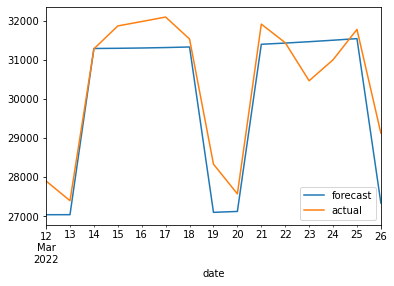

In [11]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:][first_forecast].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')

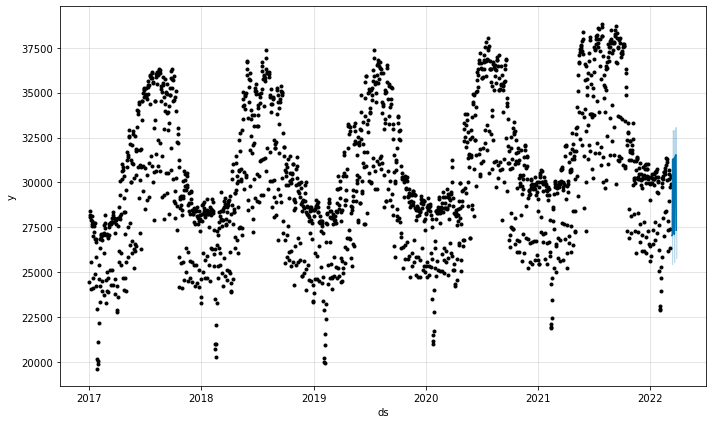

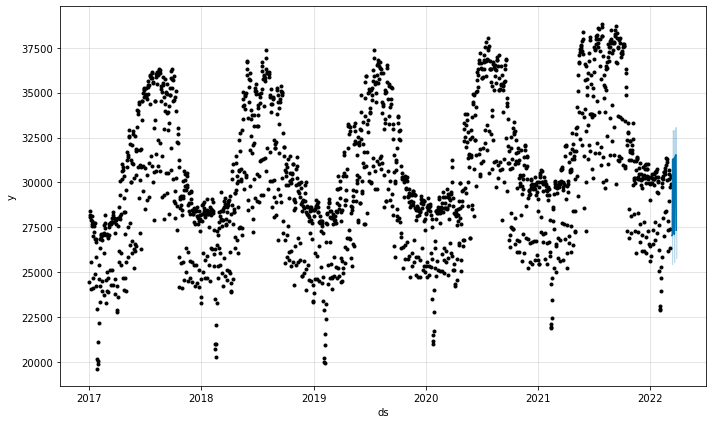

In [12]:
model.plot(forecast)

### 將預測結果代入

In [13]:
if first_forecast in dependencies:
    test[first_forecast] = forecast_simplified['forecast'].values

### 預測第二個值

In [14]:
'''
split training set and testing set
'''
train = raw_data[start_offset_second:-n_tests]
test = raw_data[-n_tests:]

In [15]:
prophet_data = train[:]
prophet_data.rename(columns={second_forecast: 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [16]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=True, 
                weekly_seasonality=False, 
                seasonality_mode='additive',
                n_changepoints=20,
                changepoint_prior_scale=100,
                seasonality_prior_scale=100)
for regressor in regressors_second:
    model.add_regressor(regressor)
model.fit(prophet_data)

Initial log joint probability = -18.49


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4103.42    0.00861729       505.753      0.7732      0.7732      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4166.8    0.00304814       134.538           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        4187.7    0.00100244       146.392           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4211.4   0.000532327       231.327      0.2659      0.2659      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4248.6     0.0410521       459.532      0.3815           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [17]:
future = test.rename(columns={'date': 'ds'})
# future.drop(['op_reserve'], axis = 1, inplace=True)
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,peak_supply
1895,2022-03-12,2,2022,3,12,5,3438.0,12.32,27045.069952
1896,2022-03-13,2,2022,3,13,6,2839.0,10.36,27045.914471
1897,2022-03-14,0,2022,3,14,0,2659.0,8.50,31291.513944
1898,2022-03-15,0,2022,3,15,1,2986.0,9.37,31296.278950
1899,2022-03-16,0,2022,3,16,2,2859.0,8.94,31303.953439


In [18]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-12,-0.893301,9.579402,13.941996,-0.893301,-0.893301,12.659509,12.659509,12.659509,-0.135278,...,16.553592,16.553592,16.553592,-3.567222,-3.567222,-3.567222,0.0,0.0,0.0,11.766208
1,2022-03-13,-0.906337,9.692270,13.886049,-0.906337,-0.906337,12.740187,12.740187,12.740187,-0.098372,...,16.553592,16.553592,16.553592,-3.522631,-3.522631,-3.522631,0.0,0.0,0.0,11.833851
2,2022-03-14,-0.919372,7.817748,12.291359,-0.919372,-0.919372,10.932666,10.932666,10.932666,-0.061465,...,16.553592,16.553592,16.553592,-3.478414,-3.478414,-3.478414,0.0,0.0,0.0,10.013294
3,2022-03-15,-0.932408,7.937549,12.038575,-0.932408,-0.932408,11.008229,11.008229,11.008229,-0.024559,...,16.553592,16.553592,16.553592,-3.435131,-3.435131,-3.435131,0.0,0.0,0.0,10.075821
4,2022-03-16,-0.945443,7.951455,12.152654,-0.945443,-0.945443,11.079509,11.079509,11.079509,0.012348,...,16.553592,16.553592,16.553592,-3.393306,-3.393306,-3.393306,0.0,0.0,0.0,10.134066


RMSE = 1.8217229012761522


<AxesSubplot:xlabel='date'>

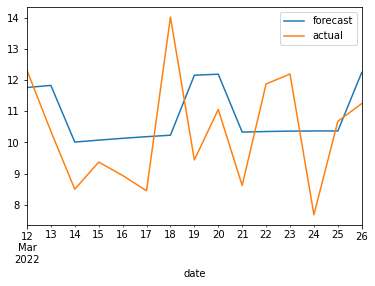

In [19]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:][second_forecast].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')

In [20]:
if second_forecast in dependencies:
    test[second_forecast] = forecast_simplified['forecast'].values

### 接著預測備轉容量

In [21]:
'''
split training set and testing set
'''
train = raw_data[start_offset_final:-n_tests]
test = raw_data[-n_tests:]

In [22]:
prophet_data = train[:]
prophet_data.rename(columns={'op_reserve': 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [23]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=False, 
                weekly_seasonality=False, 
                seasonality_mode='additive',
                changepoint_prior_scale=100,
                seasonality_prior_scale=100
                )
for regressor in regressors_op_reserve:
    model.add_regressor(regressor)
model.fit(prophet_data)

Initial log joint probability = -23.7124


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6940.41     0.0114449       9922.58           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7049.82    0.00567555       2051.99           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7146.19    0.00129028       604.686           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7159.88    0.00458532       2006.84           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7201.03   7.65361e-05        288.24      0.4158      0.4158      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [24]:
future = test.rename(columns={'date': 'ds'})
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,peak_supply
1895,2022-03-12,2,2022,3,12,5,3438.0,11.766208,27045.069952
1896,2022-03-13,2,2022,3,13,6,2839.0,11.833851,27045.914471
1897,2022-03-14,0,2022,3,14,0,2659.0,10.013294,31291.513944
1898,2022-03-15,0,2022,3,15,1,2986.0,10.075821,31296.278950
1899,2022-03-16,0,2022,3,16,2,2859.0,10.134066,31303.953439


In [25]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day_of_week,...,op_reserve_ratio,op_reserve_ratio_lower,op_reserve_ratio_upper,peak_supply,peak_supply_lower,peak_supply_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-12,3038.556877,3028.912685,3290.439553,3038.556877,3038.556877,124.267017,124.267017,124.267017,6.454960,...,481.297068,481.297068,481.297068,-339.437967,-339.437967,-339.437967,0.0,0.0,0.0,3162.823894
1,2022-03-13,3038.442569,3059.828151,3316.677351,3038.442569,3038.442569,148.287493,148.287493,148.287493,9.678188,...,502.004140,502.004140,502.004140,-339.347790,-339.347790,-339.347790,0.0,0.0,0.0,3186.730063
2,2022-03-14,3038.328261,2953.341370,3217.970616,3038.328261,3038.328261,49.008100,49.008100,49.008100,-9.661179,...,-55.313827,-55.313827,-55.313827,113.990108,113.990108,113.990108,0.0,0.0,0.0,3087.336361
3,2022-03-15,3038.213953,2983.937324,3244.008517,3038.213953,3038.213953,71.881364,71.881364,71.881364,-6.437951,...,-36.172590,-36.172590,-36.172590,114.498907,114.498907,114.498907,0.0,0.0,0.0,3110.095317
4,2022-03-16,3038.099645,3000.041446,3255.841377,3038.099645,3038.099645,93.754181,93.754181,93.754181,-3.214723,...,-18.342470,-18.342470,-18.342470,115.318376,115.318376,115.318376,0.0,0.0,0.0,3131.853826


RMSE = 525.67710114143


<AxesSubplot:xlabel='date'>

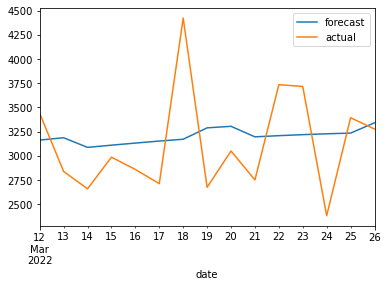

In [26]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:]['op_reserve'].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')

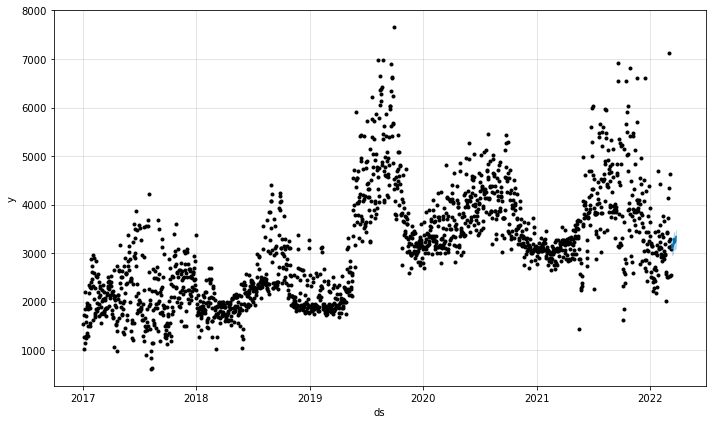

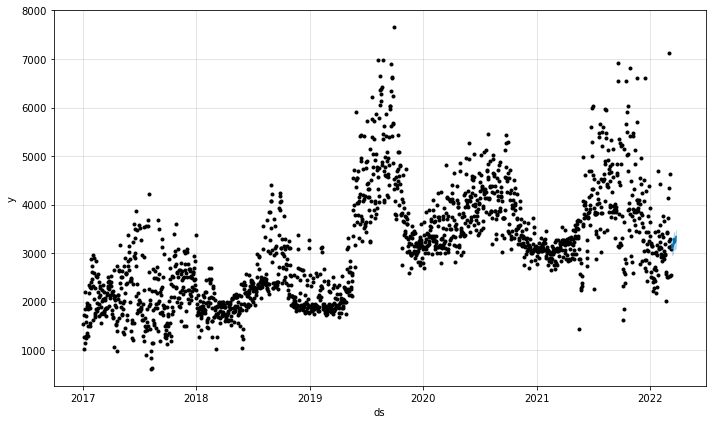

In [27]:
model.plot(forecast)

## Master Cell: Test Different Parameters
`start_offset_first`
`start_offset_second`
`multistep`